# Overview
This is the data preparation effort to developing a Machine Learning model which predicts hospital readmission within 30 days (classification problem) among diabetic patients. 

Hospital Readmission Definitions according to CMS: <br>
The 30-day risk standardized readmission measures include:
- All-cause unplanned readmissions that happen within 30 days of discharge from the index (i.e., initial) admission.
- Patients who are readmitted to the same hospital, or another applicable acute care hospital for any reason.

#### Why should we care?
[The Hospital Readmissions Reduction Program (HRRP)](https://www.cms.gov/Medicare/Medicare-Fee-for-Service-Payment/AcuteInpatientPPS/Readmissions-Reduction-Program) is a Medicare value-based purchasing program that reduces payments to hospitals with excess readmissions. The program supports the national goal of improving healthcare for Americans by linking payment to the quality of hospital care.

From the hospital standpoint, it help both the hospital clinical care team and the finance team in different ways. For the clinical care team, they can target patients with higher readmission risk based on the model to provide extra care needed that could help mitigate readmission. The model also helps Finance team maximize the funding from the government as the result of the effort to reduce hospital readmission.

#### Data
The [Clinical Database Patient Records](https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008) includes 10 years (1999–2008) of clinical care data in 130 US hospitals pertaining to patients with diabetes. [Research article](https://www.hindawi.com/journals/bmri/2014/781670/): Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records also came contributed to digging deep into this dataset.


Additional information as stated in the source website:
1. It is an inpatient encounter (a hospital admission).
2. It is a diabetic encounter, that is, one during which any kind of diabetes was entered to the system as a diagnosis.
3. The length of stay was at least 1 day and at most 14 days.
4. Laboratory tests were performed during the encounter.
5. Medications were administered during the encounter.

### Data Cleanup Steps:
1. [Drop Column](#dropcol) Drop encounter_id column as it doesn't provide any information for our objective.
2. [Readmission](#readmission) Re-map our target variable, Readmitted, into 2 labels. 1 for Readmitted within 30 days, 0 otherwise.
3. [Missing Values](#missingval) 1) Some missing values are encoded as ?, fill these in as NaN. 2) _weight, payer_code, and medical_specialty_ have over 1/3 of the values missing. Investigate and drop these columns if applicable.
5. [Diagnostics Information](#diagnostics) Re-cagtegorize three variables for diagnostic information, diag_1, diag_2, diag_3 into 9 categories as found in a [research paper.](https://www.hindawi.com/journals/bmri/2014/781670/tab2/)
6. [Remove Observations](#remove_obs)
Remove records where discharge_disposition_id = 11 which means 'Expired'. Remove records from the same patient based on rules defined by our understanding of data.

[Visualize Numeric Features](#visualize)

### Feature Engineering:
[Numeric Features](#num)
- visualization
- update numeric feature values
- bucketize numeric features

[Categorical Features](#cat)
- visualization
- drop features where no or minimum variation exists
- encode as ordinal
- aggreagate and remap values where not enough example exist for that bucket.

### Python Module
All analysis we've done on this notebook will be re-written as a python module, __*preprocessing.py*__ to be called and perform all preprocessing when exploring various models in models.ipynb. 

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

In [35]:
# load data
data = pd.read_csv('./data/diabetic_data.csv')
ids = pd.read_csv('./data/IDs_mapping.csv')

In [36]:
data.shape

(101766, 50)

In [37]:
data.isnull().sum().sum() # check for NaN

0

In [38]:
data.head(5) 

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


- although no NaN in hospital data, some values that are missing are encoded as '?'.

<a id='dropcol'></a>
### Drop encounter_id

In [39]:
df = data.drop(columns=['encounter_id']) # drop id column

<a id='readmission'></a>
### Readmission 
- 3 Categories: No, >30, <30. 

__We will recategorize this into binary class based on whether or not a patient is readmitted <30 days or not,  with 1 and 0, respectively.__

In [40]:
print(f'Original Value Counts: \n {df.readmitted.value_counts()} \n')

# Binarize
df['readmitted'] = df.readmitted.apply(lambda x: 1 if x == '<30' else 0) 
print(f'Binarized Value Counts: \n {df.readmitted.value_counts()}')

Original Value Counts: 
 NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64 

Binarized Value Counts: 
 0    90409
1    11357
Name: readmitted, dtype: int64


<a id='missingval'></a>
### Missing Value
As we've seen on data.head(), '?' encoded are our missing values. Let's replace them with actual NaN.

In [41]:
df = df.replace(r'\?', np.nan, regex=True)

In [42]:
missing = df.isnull().sum()[df.isnull().sum()>0].reset_index().rename(columns={0:'cnt'})
missing['Perc'] = ['{0:.2f}%'.format(val * 100) for val in missing['cnt']/df.shape[0]]
missing

,index,cnt,Perc
0,race,2273,2.23%
1,weight,98569,96.86%
2,payer_code,40256,39.56%
3,medical_specialty,49949,49.08%
4,diag_1,21,0.02%
5,diag_2,358,0.35%
6,diag_3,1423,1.40%


__weight, payer_code, and medical_specialty have over 1/3 of the values missing.__ <br>
It's hard to rely on these variables with such high missing value percentages on our model.
Before dropping these, let's do some simple analysis to ensure we are not missing on some important information from these variables.

*Weight*
- ~97% of our data has missing weight. 
- we should drop this in our analysis as most data are missing which prevents us from drawing trustworthy insights from this variable. 
- However, before dropping this column, let's inspect the weight and readmission relationship to ensure we are not missing out on some valuable information.

In [43]:
left = df.weight.value_counts().reset_index().rename(columns={'weight':'total_cnt'}) # value count for each weight level
weights = pd.merge(left, df.groupby(['readmitted','weight']).size().reset_index().rename(columns={0:'cnt'}),
         left_on = 'index', right_on = 'weight').drop(columns=['weight']) # form a df with # of readmitted for each weight level
weights['perc'] = weights.cnt/weights.total_cnt # add a perc column

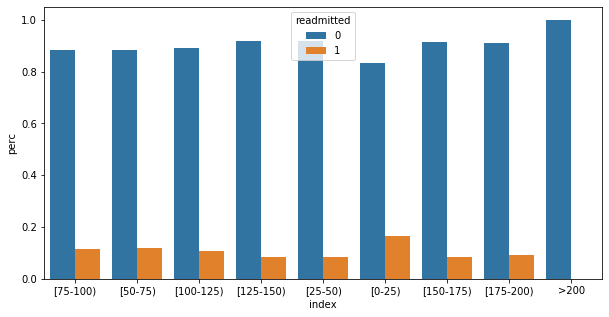

In [44]:
plt.figure(figsize = (10,5))
sns.barplot(x = 'index', y = 'perc', data = weights, hue = 'readmitted')

- as you can see above, we can not make any significant inferences with weights, although weight ranging 0-25 has slightly higher readmission rate. It's hard to make a conclusion whether the trend above is due to coincidence or is showing actual pattern. 
- let's drop this column from our analysis. In real world environment, we can work to acquire more data regarding patients weights to hopefully come back and do further analysis for this variable.

*payer_code*

- ~40% of our data has missing weight. It is unclear whether or not payer code has any correlation with readmission.
- before dropping, let's do some analysis first to see if there's anything valuable from this variable.

In [45]:
df.payer_code.value_counts()

MC    32439
HM     6274
SP     5007
BC     4655
MD     3532
CP     2533
UN     2448
CM     1937
OG     1033
PO      592
DM      549
CH      146
WC      135
OT       95
MP       79
SI       55
FR        1
Name: payer_code, dtype: int64

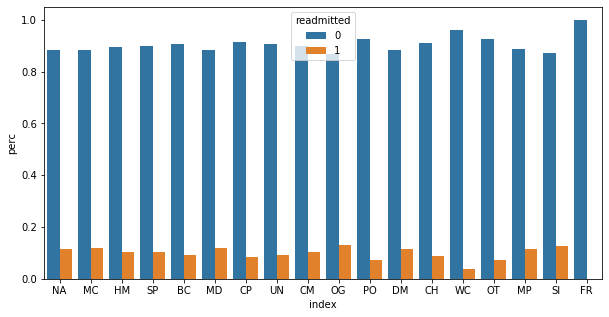

In [46]:
df.payer_code = df.payer_code.fillna('NA')
left = df.payer_code.value_counts().reset_index().rename(columns={'payer_code':'total_cnt'}) 
payercode = pd.merge(left, df.groupby(['readmitted','payer_code']).size().reset_index().rename(columns={0:'cnt'}),
         left_on = 'index', right_on = 'payer_code').drop(columns=['payer_code']) # form a df with # of readmitted for each weight level
payercode['perc'] = payercode.cnt/payercode.total_cnt # add a perc column
plt.figure(figsize = (10,5))
sns.barplot(x = 'index', y = 'perc', data = payercode, hue = 'readmitted')

- certain payer_code , i.e. MD, OG has higher percentage of readmitted percentage, while payer_code like WC has lower readmitted percentage. However, since vast majority pay_code are unknown and rest have very skewed distribution in the available pay_code that doesn't contribute much in terms of predicting readmission, we can safely drop this column as well.

*medical_specialty*

- 49% missing.
- this is a categorical variable with many possible values and potentially overlapping categories. Upon further analysis on the dataset, we find that diagnostic columns like diag_1, diag_2, diag_3 also provides the similar information in a more clean manner, so we can safely drop this column as well.

In [47]:
df['medical_specialty'].value_counts()

InternalMedicine                        14635
Emergency/Trauma                         7565
Family/GeneralPractice                   7440
Cardiology                               5352
Surgery-General                          3099
Nephrology                               1613
Orthopedics                              1400
Orthopedics-Reconstructive               1233
Radiologist                              1140
Pulmonology                               871
Psychiatry                                854
Urology                                   685
ObstetricsandGynecology                   671
Surgery-Cardiovascular/Thoracic           652
Gastroenterology                          564
Surgery-Vascular                          533
Surgery-Neuro                             468
PhysicalMedicineandRehabilitation         391
Oncology                                  348
Pediatrics                                254
Hematology/Oncology                       207
Neurology                         

#### Drop

In [48]:
df.drop(columns = ['weight','payer_code','medical_specialty'], inplace = True)

<a id='diagnostics'></a>
### Diagnostics
There were three variables for diagnostic information, diag_1, diag_2, diag_3. 

After some research, I found, https://www.hindawi.com/journals/bmri/2014/781670/tab2/ which could be used to re-categorize these into 9 categories.

|Group name|	icd9 codes|
| --- | --- |
|Circulatory|	390–459, 785|
|Respiratory|	460–519, 786|
|Digestive|	520–579, 787|
|Diabetes|	250.xx|
|Injury|	800–999|
|Musculoskeletal|	710–739|
|Genitourinary|	580–629, 788|
|Neoplasms|	140–239|
Other |001–139,  240–289 without 250, 290-389, 630–709, 740–759, 780-782, 784, 790–799,   E–V, 


In [49]:
def diag_group(x):
    try:
        x = float(x)
        if (x >= 390 and x <= 459) or x == 785:
            result = 'Circulatory'
        elif (x >= 460 and x <= 519) or x == 786:
            result = 'Respiratory'
        elif (x >= 520 and x <= 579) or x == 787:
            result = 'Digestive'
        elif x >= 250 and x < 251:
            result = 'Diabetes'
        elif x >= 800 and x <= 999:
            result = 'Injury'
        elif x >=710 and x <= 739:
            result = 'Musculoskeletal'
        elif (x >= 580 and x <=629) or x == 788:
            result = 'Genitourinary'
        elif (x >= 140 and x <= 239):
            result = 'Neoplasms'
        else:
            result = 'Other'
    except:
        result = 'Other'
    return result

In [50]:
df['diag_1'] = df['diag_1'].apply(lambda x: np.nan if x is np.nan else diag_group(x))
df['diag_2'] = df['diag_2'].apply(lambda x: np.nan if x is np.nan else diag_group(x))
df['diag_3'] = df['diag_3'].apply(lambda x: np.nan if x is np.nan else diag_group(x))

<a id="remove_obs"></a>
### Remove observations:
- Remove records where discharge_disposition_id = 11 which means 'Expired'.
- For the same patients, we see more than one records in our dataset. Upon further analysis, 

    - 16484 patients has over 1 entries in our dataset, totaling 46162 entries from these patients. 
    - Types of duplicated patients:
    
        - 1. Same patient has multiple entries (>=2 entries) and 1 of the record shows readmitted.
        
            - i.e. patient_nbr = 31320. 
            - Keep the 1 record where readmitted is 1.
            
        - 2. Same patient has multiple entries (>=2 entries) and readmitted more than 1 time.
        
            - i.e. patient_nbr = 88785891. 
            - Keep the record where readmitted is 1 and having highest time_in_hospital. Assuming the time_in_hospital is a good indicator of readmission. 
            - If multiple entries has the highest time_in_hospital, keep one record at random.
            
        - 3. Same patient having more than one entries but have no readmitted record.
        
            - i.e. patient_nbr = 189257846. 
            - Drop records at random, leaving only 1 record for each patient.
            
    - Actions: remove 46162 entries, add back 16484 unique entries for these patients based on the selection criteria above.

In [51]:
df[df['discharge_disposition_id']==11]['readmitted'].value_counts() # check that expired disposition ids have no hospital readmission.

0    1642
Name: readmitted, dtype: int64

In [52]:
df = df[df['discharge_disposition_id']!=11]

In [53]:
dupe_patients=df[df.duplicated('patient_nbr', False)].sort_values(by='patient_nbr')
a= dupe_patients.groupby('patient_nbr').size().reset_index().rename(columns={0:'entry_count'})
b= dupe_patients.groupby('patient_nbr').sum()[['readmitted']].reset_index()
dupes = pd.merge(a,b,on = 'patient_nbr')

print(dupes.sample(5))
print(f'\nTotal duplicated entries in the dataset: {dupe_patients.shape}')
print(f'check: {np.sum(dupes.entry_count)}')

patients_manyEntries = dupes.patient_nbr.tolist()
patients_readmittedOnce = dupes[dupes['readmitted']==1]['patient_nbr'].tolist() # scenario 1
patients_readmittedMany = dupes[dupes['readmitted']>1]['patient_nbr'].tolist() # scenario 2
patients_notreadmitted = dupes[dupes['readmitted']==0]['patient_nbr'].tolist() # scenario 3

      patient_nbr  entry_count  readmitted
9235     54643194            2           0
5223     24726600            2           0
3310     18497115            3           0
1751      3707856            2           0
9375     56456451            2           0

Total duplicated entries in the dataset: (46162, 46)
check: 46162


In [54]:
seedn = 1234
def drop_patients_readmittedOnce(patient_num):
    tmp = df[np.logical_and(df['patient_nbr']==patient_num,df['readmitted']==1)]
    return tmp.values.tolist()[0]

def drop_patients_readmittedMany(patient_num):
    tmp = df[np.logical_and(df['patient_nbr']==patient_num,df['readmitted']==1)]
    tmp = tmp[tmp['time_in_hospital']==max(tmp['time_in_hospital'])]
    np.random.seed(seedn)
    idx = np.random.permutation(np.arange(len(tmp)))
    tmp = tmp.iloc[idx].drop_duplicates('patient_nbr')
    return tmp.values.tolist()[0]

def drop_patients_notreadmitted(patient_num):
    tmp = df[df['patient_nbr']==patient_num]
    np.random.seed(seedn)
    idx = np.random.permutation(np.arange(len(tmp)))
    tmp = tmp.iloc[idx].drop_duplicates('patient_nbr')
    return tmp.values.tolist()[0]


In [55]:
df2 = df.copy()
df2 = df2[~df2['patient_nbr'].isin(patients_manyEntries)]

In [56]:
list_once = []
for n in patients_readmittedOnce:
    list_once.append(drop_patients_readmittedOnce(n))
list_many = []
for n in patients_readmittedMany:
    list_many.append(drop_patients_readmittedMany(n))
list_none = []
for n in patients_notreadmitted:
    list_none.append(drop_patients_notreadmitted(n))

In [57]:
add = pd.concat([pd.DataFrame(list_once), pd.DataFrame(list_many), pd.DataFrame(list_none)], axis=0)
add.columns = df2.columns
df = pd.concat([df2, add], axis=0)

<a id='num'></a>
## Numeric Features
### Histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12947f1d0>,
      dtype=object)

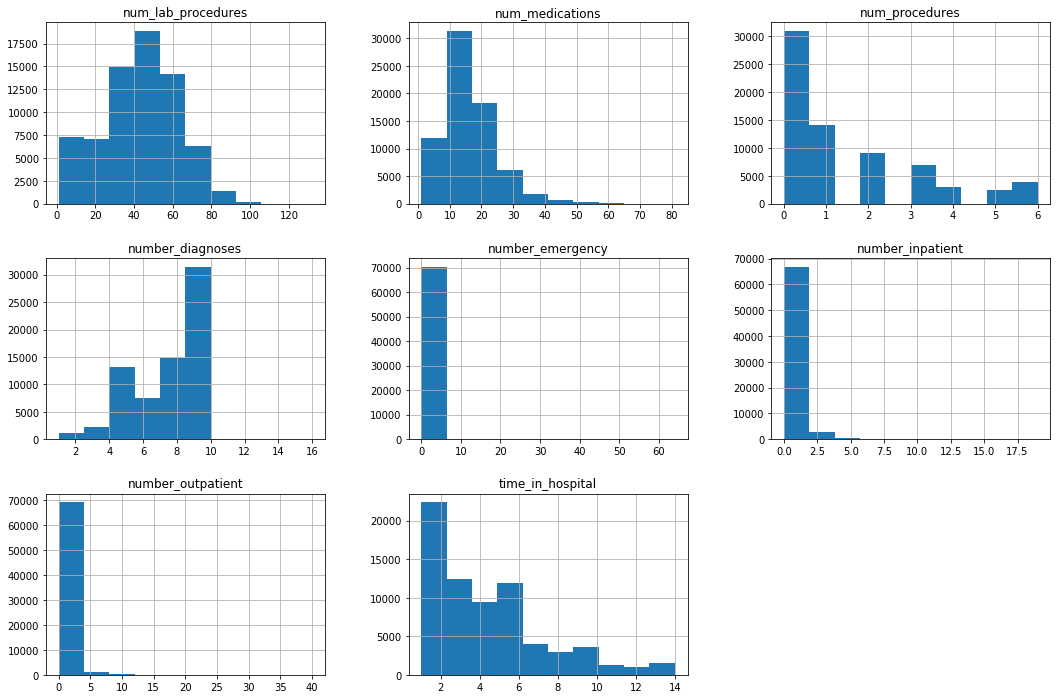

In [26]:
NUM_COLS = ['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient',
           'number_emergency','number_inpatient','number_diagnoses']
df[NUM_COLS].hist(figsize = (18,12)) # histogram

### Numeric features and Readmission percentage

    count  time_in_hospital  readmitted      perc
0   10327                 1         802  0.077661
1   12080                 2        1179  0.097599
2   12499                 3        1399  0.111929
3    9474                 4        1196  0.126240
4    6766                 5         954  0.140999
5    5159                 6         794  0.153906
6    3938                 7         638  0.162011
7    2948                 8         544  0.184532
8    1985                 9         369  0.185894
9    1589                10         316  0.198867
10   1222                11         181  0.148118
11    967                12         186  0.192347
12    804                13         143  0.177861
13    688                14         133  0.193314


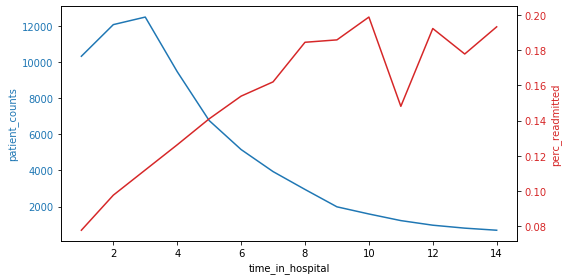

     count  num_lab_procedures  readmitted      perc
0     2234                   1         223  0.099821
1      762                   2          85  0.111549
2      492                   3          47  0.095528
3      282                   4          17  0.060284
4      212                   5          22  0.103774
5      195                   6          13  0.066667
6      254                   7          16  0.062992
7      251                   8          19  0.075697
8      676                   9          77  0.113905
9      578                  10          58  0.100346
10     486                  11          48  0.098765
11     367                  12          41  0.111717
12     291                  13          26  0.089347
13     255                  14          31  0.121569
14     291                  15          40  0.137457
15     365                  16          51  0.139726
16     476                  17          45  0.094538
17     487                  18          55  0.

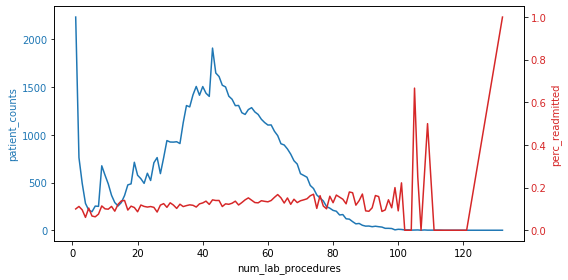

   count  num_procedures  readmitted      perc
0  30938               0        3821  0.123505
1  14194               1        1920  0.135268
2   9071               2        1154  0.127219
3   7008               3         850  0.121290
4   3008               4         406  0.134973
5   2377               5         260  0.109382
6   3850               6         423  0.109870


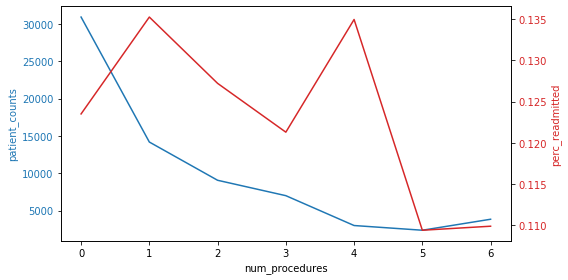

    count  num_medications  readmitted      perc
0     211                1           8  0.037915
1     384                2          27  0.070312
2     713                3          50  0.070126
3    1134                4          78  0.068783
4    1569                5         112  0.071383
5    2080                6         179  0.086058
6    2641                7         227  0.085952
7    3204                8         315  0.098315
8    3574                9         354  0.099049
9    3840               10         407  0.105990
10   4013               11         465  0.115873
11   4217               12         486  0.115248
12   4229               13         503  0.118941
13   3858               14         456  0.118196
14   3927               15         527  0.134199
15   3637               16         477  0.131152
16   3296               17         455  0.138046
17   2980               18         427  0.143289
18   2653               19         369  0.139088
19   2411           

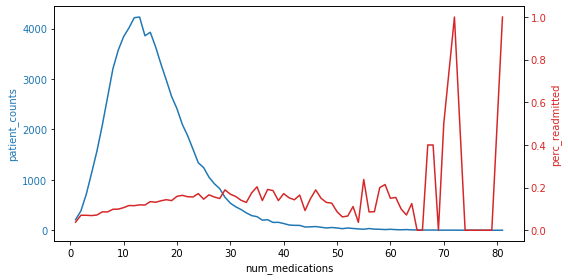

    count  number_outpatient  readmitted      perc
0   60948                  0        7235  0.118708
1    4937                  1         834  0.168928
2    2063                  2         335  0.162385
3    1145                  3         174  0.151965
4     611                  4         117  0.191489
5     294                  5          51  0.173469
6     141                  6          31  0.219858
7      80                  7          17  0.212500
8      54                  8           4  0.074074
9      38                  9          13  0.342105
10     27                 10           2  0.074074
11     17                 11           1  0.058824
12     16                 12           4  0.250000
13     16                 13           5  0.312500
14     12                 14           4  0.333333
15     11                 15           2  0.181818
16      7                 16           0  0.000000
17      5                 17           1  0.200000
18      3                 18   

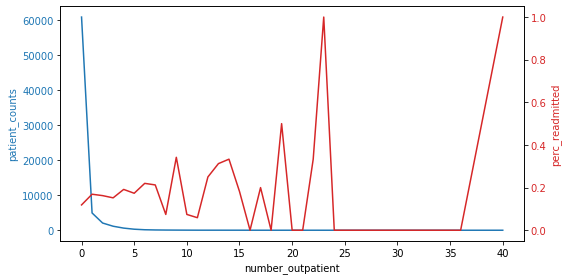

    count  number_emergency  readmitted      perc
0   65013                 0        7647  0.117623
1    4050                 1         766  0.189136
2     854                 2         224  0.262295
3     284                 3          87  0.306338
4     114                 4          55  0.482456
5      48                 5          21  0.437500
6      32                 6          11  0.343750
7       7                 7           1  0.142857
8      12                 8           5  0.416667
9       7                 9           2  0.285714
10      8                10           3  0.375000
11      5                11           5  1.000000
12      2                12           2  1.000000
13      2                13           1  0.500000
14      2                16           2  1.000000
15      1                20           0  0.000000
16      1                25           0  0.000000
17      1                28           1  1.000000
18      1                37           0  0.000000


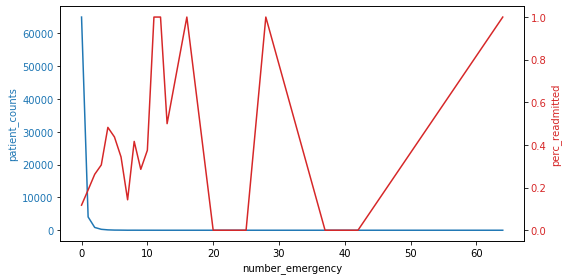

    count  number_inpatient  readmitted      perc
0   60120                 0        5214  0.086727
1    6744                 1        1969  0.291963
2    2120                 2         871  0.410849
3     756                 3         369  0.488095
4     341                 4         176  0.516129
5     168                 5          95  0.565476
6      98                 6          67  0.683673
7      36                 7          27  0.750000
8      29                 8          19  0.655172
9      11                 9           6  0.545455
10      9                10           8  0.888889
11      2                11           1  0.500000
12      8                12           8  1.000000
13      3                15           3  1.000000
14      1                19           1  1.000000


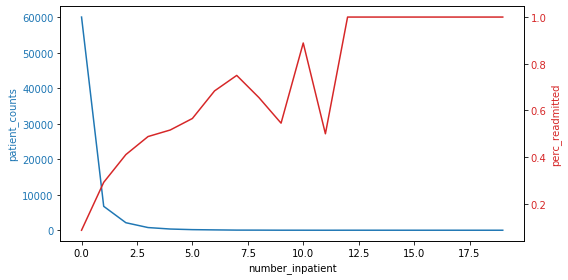

    count  number_diagnoses  readmitted      perc
0     191                 1           6  0.031414
1     859                 2          43  0.050058
2    2315                 3         154  0.066523
3    4369                 4         350  0.080110
4    8781                 5         826  0.094067
5    7531                 6         841  0.111672
6    7452                 7         863  0.115808
7    7427                 8         985  0.132624
8   31451                 9        4754  0.151156
9       7                10           2  0.285714
10      7                11           1  0.142857
11      5                12           1  0.200000
12     11                13           3  0.272727
13      3                14           0  0.000000
14      7                15           2  0.285714
15     30                16           3  0.100000


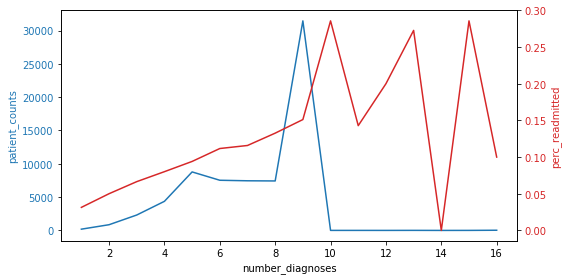

In [107]:
def plot_num_feat(colname):
    
    data1 = df[colname].value_counts().reset_index().sort_values(by='index').reset_index(drop=True)
    data2 = df.groupby(colname).sum()['readmitted'].reset_index()
    x=data2[colname]
    y1=data1[colname] # value count of no. of patients having the value.
    y2=data2['readmitted']/y1 # calculate percent readmitted = readmitted / count
    print(pd.concat([data1.rename(columns={colname:'count'}), data2, y2], axis=1).rename(columns={0:'perc'}).drop(columns=['index']))
    fig, ax1 = plt.subplots(figsize=(8,4))
    color = 'tab:blue'
    ax1.set_xlabel(colname)
    ax1.set_ylabel('patient_counts', color=color)
    ax1.plot(x, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:red'
    ax2.set_ylabel('perc_readmitted', color=color) # we already handled the x-label with ax1
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    
for col in NUM_COLS:
    plot_num_feat(col)

<a id='update'></a>
## Update values
### time_in_hospital, num_inpatient, number_diagnoses
<br>
The higher the time in hospital, the higher percentage of patients are readmitted to hospital __untill time_in_hospital reaches 10__. After 10 days, we see that the chance of readmission doesn't increase with the time spent in hospital. 

We can recode time_in_hospital > 10 to 10.

Similarly, for num_inpatient and number_diagnoses, we will record values > 10 as 10.

In [28]:
for col in ['time_in_hospital','number_inpatient','number_diagnoses']:
    df[col] = df[col].apply(lambda x: 10 if x > 10 else x)

<a id='bucketize'></a>
## Bucketize
### num_lab_procedures
- we see num_lab_procedures ranging from 0 - 132 in our training data and the distribution is scarce when it's over 100. 
- one thing we can do is to bucketize this column to ensure each bucket ensuring each bucket represent similar population.
- Using sklearn's kbinsDiscretizer, bucketize the numbers into 4 bins.

In [29]:
df.reset_index(drop=True, inplace=True)
# df2 = df.copy()

In [30]:
from sklearn.preprocessing import KBinsDiscretizer
kbins = KBinsDiscretizer(n_bins = 4, strategy = 'uniform')
transformed = kbins.fit_transform(df[['num_lab_procedures']]).toarray()
df = pd.concat([df, pd.DataFrame(transformed, columns=['num_lab_procedures_' + str(i) for i in kbins.bin_edges_[0]][:-1])], axis=1)

### num_procedures, num_medications, number_outpatient, number_emergency
Based on the graph, the higher number of procedure doesn't directly link to higher chances of readmission.
However, the number of procedure still may be useful information.
we can bucketize and dummify these into 3 buckets, 0-2, 2-4, 4-6. (low, medium, high)

For similar reasons, encode num_medication, number_outpatient, number_emergency into 3 bins - we can interpret these as low, medium, high

In [31]:
from sklearn.preprocessing import KBinsDiscretizer
dic = {}
for col in ['num_procedures','num_medications','number_outpatient']:
    kbins = KBinsDiscretizer(n_bins = 3, strategy = 'uniform')
    transformed = kbins.fit_transform(df[[col]]).toarray()
    dic[tuple([col + '_' + str(round(i,2)) for i in kbins.bin_edges_[0].tolist()[:-1]])]=transformed

In [32]:
for key in dic:
    tmp = pd.DataFrame(dic[key], columns=key)
    df = pd.concat([df, tmp], axis=1)

In [33]:
df.sample(10)

,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,num_lab_procedures_1.0,num_lab_procedures_33.75,num_lab_procedures_66.5,num_lab_procedures_99.25,num_procedures_0.0,num_procedures_2.0,num_procedures_4.0,num_medications_1.0,num_medications_27.67,num_medications_54.33,number_outpatient_0.0,number_outpatient_13.33,number_outpatient_26.67
12201,86822154,Caucasian,Female,[80-90),3,3,1,3,52,1,14,0,0,0,Musculoskeletal,Diabetes,Other,6,None,None,No,No,No,No,No,No,Down,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Ch,Yes,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
25165,78944112,Caucasian,Female,[40-50),1,1,7,4,34,1,11,0,0,0,Other,Diabetes,Other,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
44128,79464051,AfricanAmerican,Female,[60-70),6,1,17,4,48,0,11,0,0,0,Digestive,Other,Circulatory,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
62973,23402142,Caucasian,Female,[60-70),1,6,17,1,17,0,9,0,0,0,Circulatory,Diabetes,Musculoskeletal,5,Norm,None,No,No,No,No,No,No,Steady,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,Ch,Yes,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
33469,61236738,Caucasian,Female,[70-80),1,6,7,10,40,0,22,5,0,0,Other,Circulatory,Circulatory,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
8618,3211587,Caucasian,Male,[80-90),1,18,7,4,49,0,11,0,0,0,Circulatory,Respiratory,Circulatory,9,None,>8,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
30328,52600248,Caucasian,Male,[60-70),5,1,1,2,8,1,10,0,0,0,Genitourinary,Diabetes,Genitourinary,9,None,None,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
21018,10530315,Caucasian,Male,[70-80),1,1,6,5,60,0,11,0,0,0,Diabetes,Circulatory,Genitourinary,5,None,None,Down,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Ch,Yes,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
61419,2843730,Caucasian,Male,[70-80),1,1,7,4,48,3,15,0,0,0,Circulatory,Circulatory,Circulatory,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,Yes,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2191,675900,Caucasian,Female,[60-70),1,1,7,2,50,2,4,0,0,0,Circulatory,Diabetes,Diabetes,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


<a id='cat'></a>
## Categorical Features

In [151]:
CAT_COLS = df.select_dtypes('object').columns
CAT_COLS

Index(['race', 'gender', 'age', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum',
       'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed'],
      dtype='object')

### Visualize

   count             race  readmitted      perc
0  12696  AfricanAmerican        1605  0.126418
1    493            Asian          50  0.101420
2  52681        Caucasian        6734  0.127826
3   1502         Hispanic         164  0.109188
4   1163            Other         118  0.101462


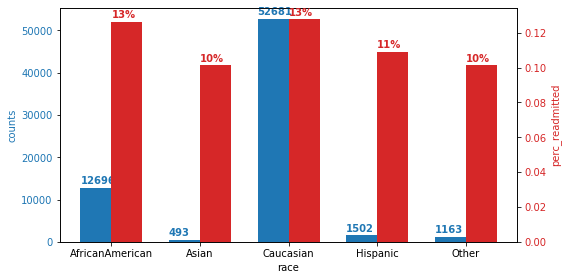

   count           gender  readmitted      perc
0  37475           Female        4754  0.126858
1  32968             Male        4080  0.123756
2      3  Unknown/Invalid           0  0.000000


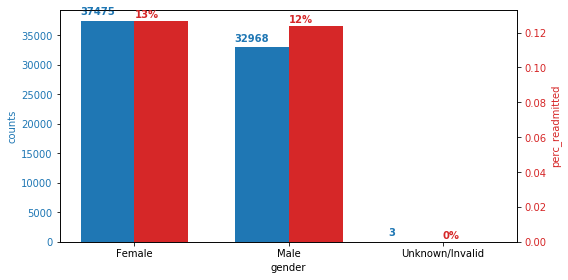

   count       age  readmitted      perc
0    153    [0-10)           3  0.019608
1    533   [10-20)          31  0.058161
2   1116   [20-30)         121  0.108423
3   2685   [30-40)         285  0.106145
4   6816   [40-50)         706  0.103580
5  12343   [50-60)        1255  0.101677
6  15770   [60-70)        1975  0.125238
7  17871   [70-80)        2491  0.139388
8  11323   [80-90)        1712  0.151197
9   1836  [90-100)         255  0.138889


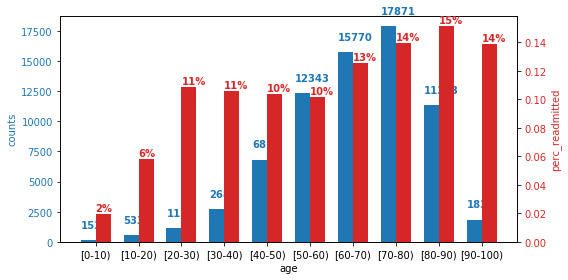

   count           diag_1  readmitted      perc
0  21470      Circulatory        2835  0.132045
1   5718         Diabetes         776  0.135712
2   6525        Digestive         770  0.118008
3   3504    Genitourinary         457  0.130422
4   4745           Injury         692  0.145838
5   4068  Musculoskeletal         416  0.102262
6   2657        Neoplasms         294  0.110651
7  12209            Other        1542  0.126300
8   9537      Respiratory        1048  0.109888


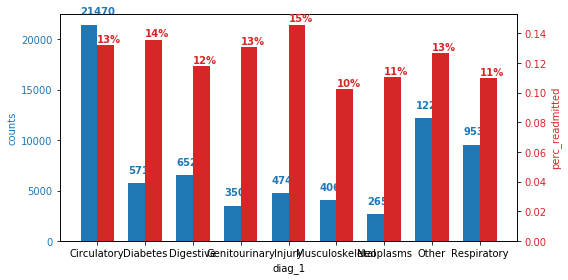

   count           diag_2  readmitted      perc
0  22138      Circulatory        2828  0.127744
1   9609         Diabetes        1048  0.109064
2   2903        Digestive         361  0.124354
3   5434    Genitourinary         745  0.137100
4   1844           Injury         237  0.128525
5   1306  Musculoskeletal         151  0.115620
6   1699        Neoplasms         283  0.166569
7  18209            Other        2277  0.125048
8   7010      Respiratory         888  0.126676


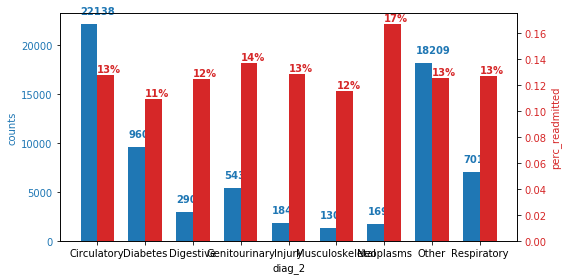

   count           diag_3  readmitted      perc
0  20896      Circulatory        2620  0.125383
1  12492         Diabetes        1407  0.112632
2   2692        Digestive         331  0.122957
3   4189    Genitourinary         668  0.159465
4   1422           Injury         194  0.136428
5   1368  Musculoskeletal         157  0.114766
6   1238        Neoplasms         200  0.161551
7  20214            Other        2489  0.123132
8   4737      Respiratory         706  0.149039


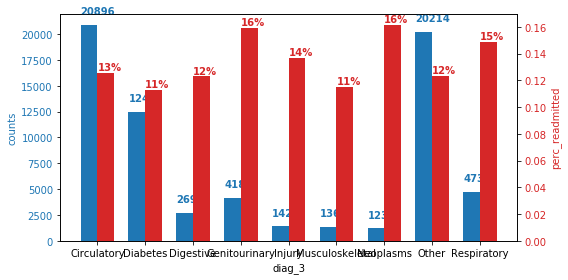

   count max_glu_serum  readmitted      perc
0    954          >200         151  0.158281
1    726          >300         124  0.170799
2  67061          None        8331  0.124230
3   1705          Norm         228  0.133724


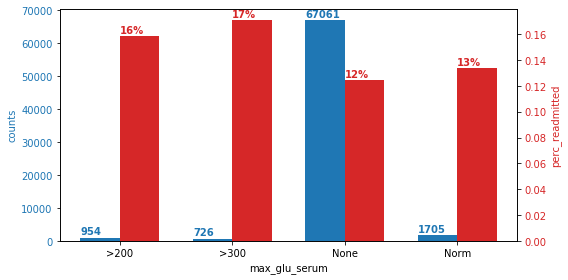

   count A1Cresult  readmitted      perc
0   2867        >7         333  0.116149
1   6199        >8         671  0.108243
2  57629      None        7412  0.128616
3   3751      Norm         418  0.111437


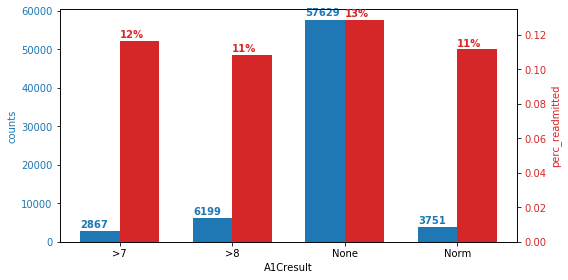

   count metformin  readmitted      perc
0    442      Down          57  0.128959
1  55576        No        7216  0.129840
2  13600    Steady        1485  0.109191
3    828        Up          76  0.091787


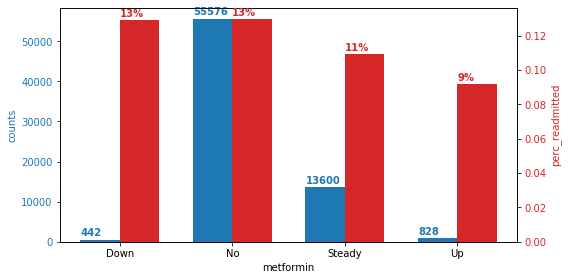

   count repaglinide  readmitted      perc
0     30        Down           3  0.100000
1  69532          No        8668  0.124662
2    808      Steady         144  0.178218
3     76          Up          19  0.250000


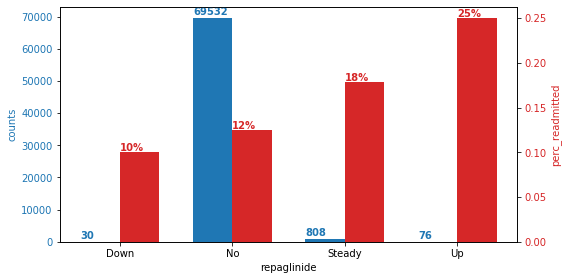

   count nateglinide  readmitted      perc
0      9        Down           1  0.111111
1  69950          No        8769  0.125361
2    472      Steady          64  0.135593
3     15          Up           0  0.000000


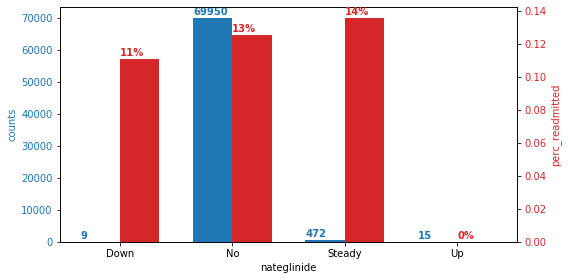

   count chlorpropamide  readmitted      perc
0      1           Down           0  0.000000
1  70376             No        8830  0.125469
2     65         Steady           4  0.061538
3      4             Up           0  0.000000


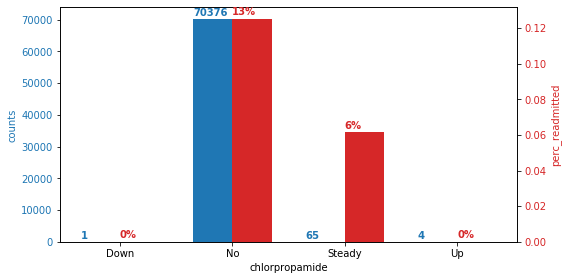

   count glimepiride  readmitted      perc
0    135        Down          21  0.155556
1  66752          No        8397  0.125794
2   3323      Steady         382  0.114956
3    236          Up          34  0.144068


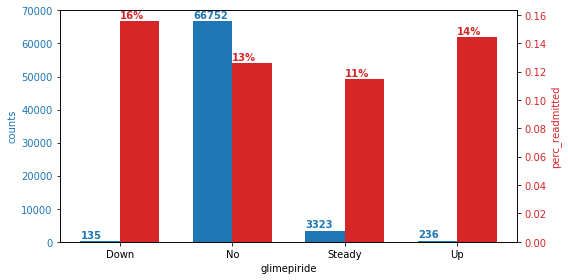

   count acetohexamide  readmitted      perc
0  70445            No        8834  0.125403
1      1        Steady           0  0.000000


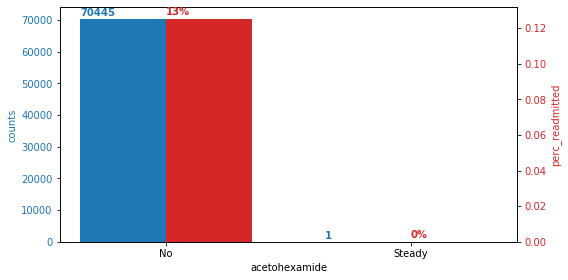

   count glipizide  readmitted      perc
0    382      Down          72  0.188482
1  61454        No        7645  0.124402
2   8030    Steady        1031  0.128394
3    580        Up          86  0.148276


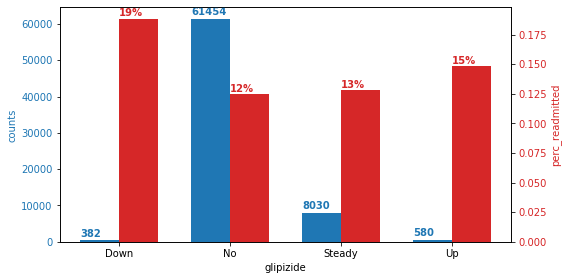

   count glyburide  readmitted      perc
0    409      Down          45  0.110024
1  62695        No        7882  0.125720
2   6731    Steady         831  0.123459
3    611        Up          76  0.124386


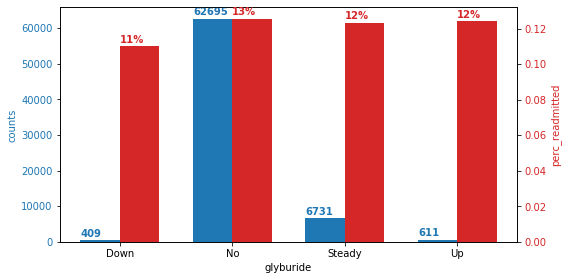

   count tolbutamide  readmitted      perc
0  70429          No        8833  0.125417
1     17      Steady           1  0.058824


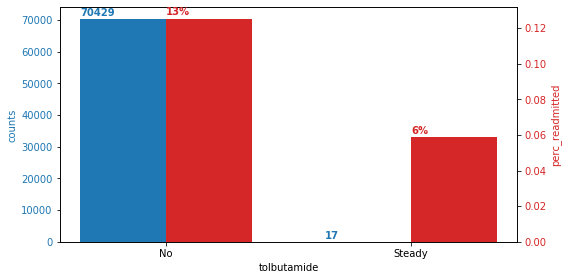

   count pioglitazone  readmitted      perc
0     84         Down          17  0.202381
1  65181           No        8207  0.125911
2   5002       Steady         582  0.116353
3    179           Up          28  0.156425


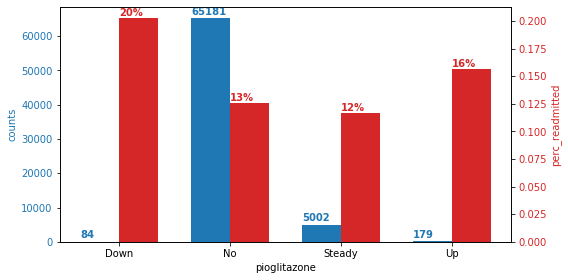

   count rosiglitazone  readmitted      perc
0     75          Down           5  0.066667
1  65830            No        8284  0.125839
2   4408        Steady         527  0.119555
3    133            Up          18  0.135338


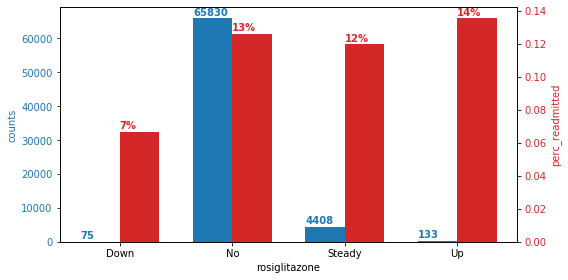

   count acarbose  readmitted      perc
0  70248       No        8812  0.125441
1    188   Steady          20  0.106383
2     10       Up           2  0.200000


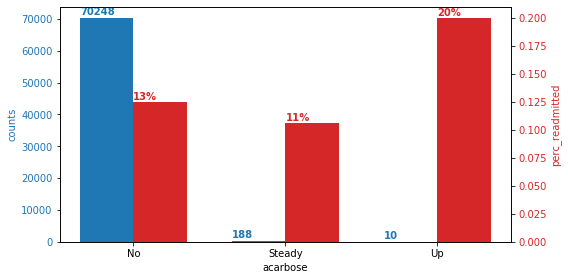

   count miglitol  readmitted      perc
0      2     Down           1  0.500000
1  70426       No        8832  0.125408
2     18   Steady           1  0.055556


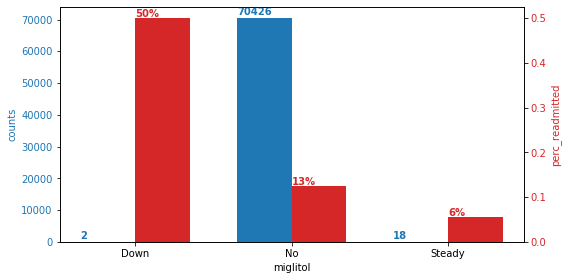

   count troglitazone  readmitted      perc
0  70444           No        8834  0.125405
1      2       Steady           0  0.000000


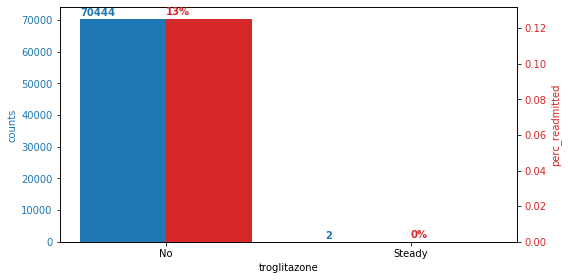

   count tolazamide  readmitted      perc
0  70414         No        8831  0.125415
1     32     Steady           3  0.093750


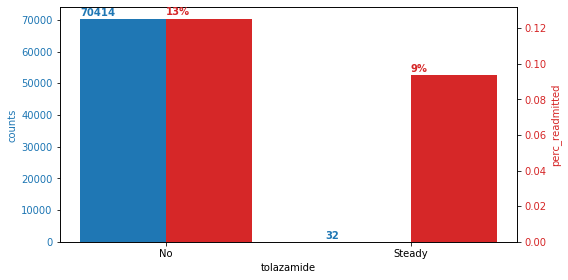

   count examide  readmitted      perc
0  70446      No        8834  0.125401


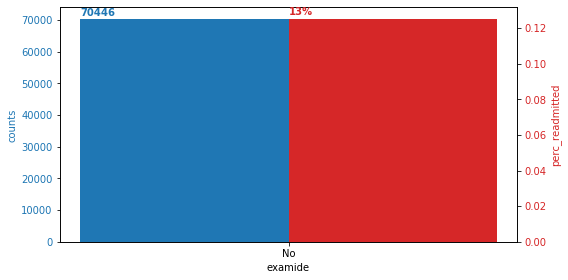

   count citoglipton  readmitted      perc
0  70446          No        8834  0.125401


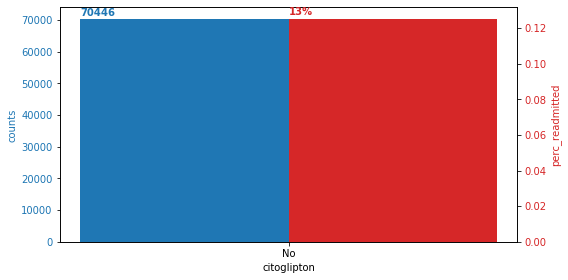

   count insulin  readmitted      perc
0   7500    Down        1260  0.168000
1  34246      No        3746  0.109385
2  21776  Steady        2748  0.126194
3   6924      Up        1080  0.155979


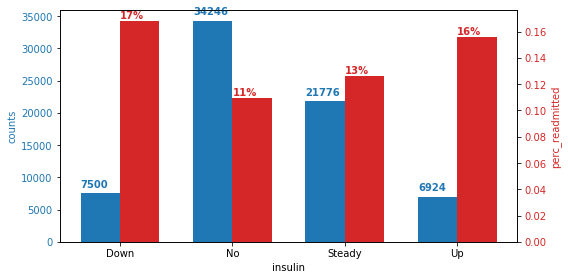

   count glyburide-metformin  readmitted      perc
0      4                Down           1  0.250000
1  69960                  No        8774  0.125415
2    475              Steady          59  0.124211
3      7                  Up           0  0.000000


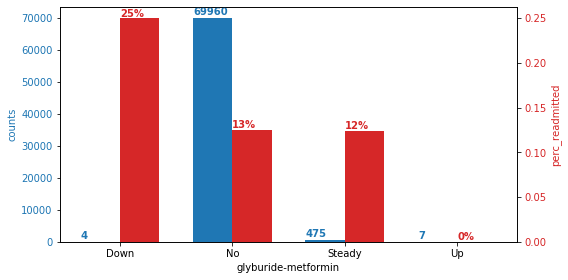

   count glipizide-metformin  readmitted      perc
0  70439                  No        8833  0.125399
1      7              Steady           1  0.142857


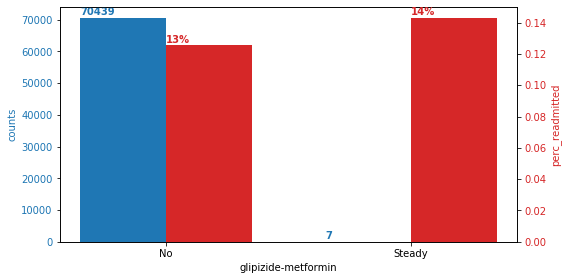

   count glimepiride-pioglitazone  readmitted      perc
0  70446                       No        8834  0.125401


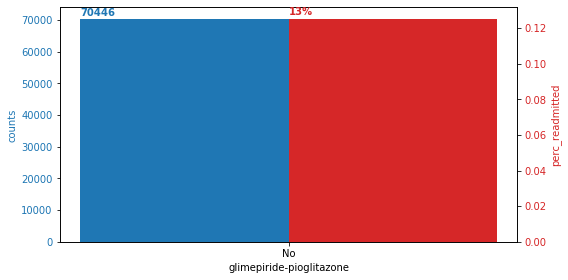

   count metformin-rosiglitazone  readmitted      perc
0  70444                      No        8834  0.125405
1      2                  Steady           0  0.000000


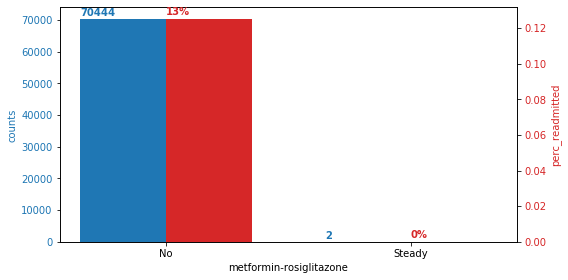

   count metformin-pioglitazone  readmitted      perc
0  70445                     No        8834  0.125403
1      1                 Steady           0  0.000000


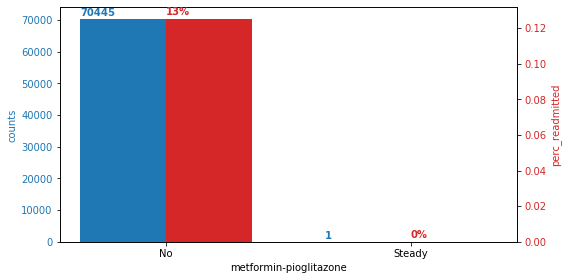

   count change  readmitted      perc
0  31806     Ch        4371  0.137427
1  38640     No        4463  0.115502


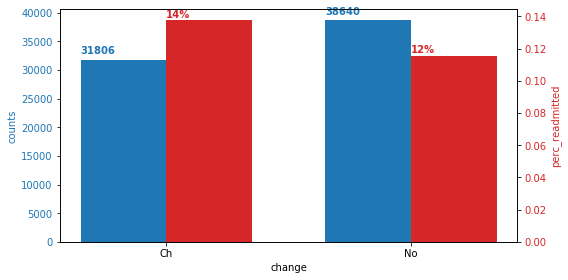

   count diabetesMed  readmitted      perc
0  16803          No        1716  0.102125
1  53643         Yes        7118  0.132692


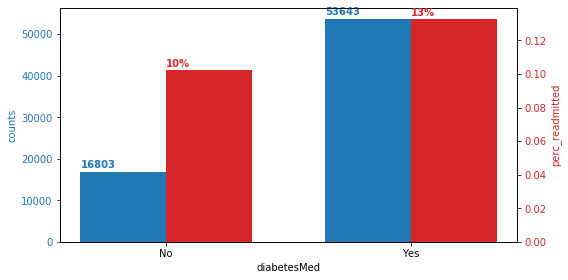

In [150]:
def plot_cat_cols(colname):
    data1 = df[colname].value_counts().reset_index().sort_values(by='index').reset_index(drop=True)
    data2 = df.groupby(colname).sum()[['readmitted']].reset_index()
    x = data2[colname]
    y1 = data1[colname] # count of patients having the specific value for the categorical column.
    y2 = data2['readmitted']/data1[colname] # calculate percent readmitted = readmitted / count
    print(pd.concat([data1.rename(columns={colname:'count'}), data2, y2], axis=1).rename(columns={0:'perc'}).drop(columns=['index']))

    ind = np.arange(data2.shape[0]) # set index for x axis
    width = 0.35 # bar width

    color1 = 'tab:blue'
    fig, ax1 = plt.subplots(figsize=(8,4))
    ax1.set_xlabel(colname)
    ax1.set_ylabel('counts', color=color1)
    ax1.bar(ind, y1, width=width, color=color1, label = 'count')
    ax1.tick_params(axis='y', labelcolor=color1)
    for i, v in enumerate(y1): # show number on top of bar
        ax1.text(i-width/2, v+1000,  str(v), color=color1, fontweight='bold')



    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color2 = 'tab:red'
    ax2.set_ylabel('perc_readmitted', color=color2) # we already handled the x-label with ax1
    ax2.bar(ind + width, y2, width=width, color=color2, label = 'perc')
    ax2.tick_params(axis='y', labelcolor=color2)
    for i, v in enumerate(y2): # show number on top of bar
        ax2.text(i + width/2, v+.002,  str(round(v*100))+'%', color=color2, fontweight='bold')

    plt.xticks(ind + width / 2, data2[colname].tolist())

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    
for col in df.select_dtypes('object').columns:
    plot_cat_cols(col)

__race, diag1, diag2, diag3, metformin, repaglinide, change, diabetesMed__<br>
We will leave these columns as is and use dummification during training time when we build the pipeline.
- race has 1909 missing value, we will use k nears neighbor to impute race using all numeric columns: 'time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient',
           'number_emergency','number_inpatient','number_diagnoses'
- diag1 diag2 diag3 also contains some missing values. we will use the same KNN strategy to Impute missing data.

__gender__<br>
we will drop 3 examples where sex is Unknown or Invalid, these examples do not have readmitted patients so dropping 3 examples in our large dataset will not affect our models much.

__age__<br>
we can see that in general the older the patient, the higher the chance of readmission.<br>
we will encode these into the following ordinal: 1 to 10. <br>

__max_glu_serum__<br>
we will encode max_glu_serum into the following ordinal value: <br>
- 0 - None
- 1 - norm
- 2 - greater than 200
- 3 - greater than 300

__A1Cresult__<br>
- 0 - None
- 1 - norm
- 2 - greater than 7
- 3 - greater than 8

__metformin, repaglinide, nateglinide, glimepiride, glyburide, rosiglitazone__ <br>
 - Down, No, Steady, Up.

__chlorpropamide, tolbutamide, miglitol, tolazamide, glyburide-metformin__<br>
we don't have enough examples in the Down and Up bucket. <br>
We can remap this column in to 2 values: 
- Steady, Otherwise(No, Up, Down).

__glimepiride, glipizide, pioglitazone, acarbose, insulin__<br>
- steady, unsteady (Up or Down), No


__acetohexamide, troglitazone, examide, citoglipton, glipizide-metformin, glimepiride-pioglitazone, glimepiride-pioglitazone, metformin-rosiglitazone, metformin-pioglitazone__ <br>
- No or minimum variation in data. Drop columns.
- Refer to models.ipynb where we built two models with and without these columns and the result showed very little to almost no difference.
